<h1><center>CS 455/595a: Ensemble Methods - bagging and random forests</center></h1>
<center>Richard S. Stansbury</center>

This notebook applies the bagging and random forest ensemble classification and regression concepts concepts covered in [1] with the [Titanic](https://www.kaggle.com/c/titanic/) and [Boston Housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) data sets for DT-based classification and regression, respectively.

Note: you must install the graphviz package for Python.  Please do this install using pip or conda. i.e.  "conda install graphviz"

Reference:

[1] Aurelen Geron. *Hands on Machine Learning with Scikit-Learn & TensorFlow* O'Reilley Media Inc, 2017.

[2] Aurelen Geron. "ageron/handson-ml: A series of Jupyter notebooks that walk you through the fundamentals of Machine Learning and Deep Learning in python using Scikit-Learn and TensorFlow." Github.com, online at: https://github.com/ageron/handson-ml [last accessed 2019-03-01]

**Table of Contents**
1. [Titanic Survivor Ensemble Classifiers](#Titanic-Survivor-Classifier)
 
2. [Boston Housing Cost Ensemble Regressors](#Boston-Housing-Cost-Estimator)

# Titanic Survivor Classifier

## Set up - Imports of libraries and Data Preparation

In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn import datasets

from matplotlib import pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd
import os

# Read data from input files into Pandas data frames
data_path = os.path.join("datasets","titanic")
train_filename = "train.csv"
test_filename = "test.csv"

def read_csv(data_path, filename):
    joined_path = os.path.join(data_path, filename)
    return pd.read_csv(joined_path)

# Read CSV file into Pandas Dataframes
train_df = read_csv(data_path, train_filename)

# Defining Data Pre-Processing Pipelines
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes):
        self.attributes = attributes
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes]

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X], 
                                       index = X.columns)
        return self
    
    def transform(self, X):
        return X.fillna(self.most_frequent)

    
numeric_pipe = Pipeline([
        ("Select", DataFrameSelector(["Age", "Fare", "SibSp", "Parch"])), # Selects Fields from dataframe
        ("Imputer", SimpleImputer(strategy="median")),   # Fills in NaN w/ median value for its column
    ])

#Handle categorical string for sex by encoding as female true, 1 or false,0
train_df['Female'] = train_df["Sex"].apply(lambda x: 1 if x == 'female' else 0)

categories_pipe = Pipeline([
        ("Select", DataFrameSelector(["Pclass", "Female"])), # Selects Fields from dataframe
        ("MostFreqImp", MostFrequentImputer()), # Fill in NaN with most frequent
    ])

preprocessing_pipe = FeatureUnion(transformer_list = [
        ("numeric pipeline", numeric_pipe), 
        ("categories pipeline", categories_pipe)
     ]) 

# Process Input Data Using Pipleines
train_X_data = preprocessing_pipe.fit_transform(train_df)

train_y_data = train_df["Survived"]

feature_names = ["Age", "Fare", "SibSp", "Parch", "Class", "Female"]
target_names = ["Died","Survived"]

## KNN Classifier Performance vs. Metrics (for comparison)

This example is included for comparison by showing the cross validation metric scores for a KNN classifier on the titanic data set.

In [2]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Classifier 10-fold Validation
k=10
clf = KNeighborsClassifier(n_neighbors=k)

y_pred = cross_val_predict(clf, train_X_data, train_y_data, cv=5)

print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))                            
                               

Confusion Matrix:
[[451  98]
 [176 166]]
Accuracy Score = 0.6924803591470258
Pecision Score = 0.6287878787878788
Recall Score = 0.4853801169590643
F1 Score = 0.5478547854785478


## Bagging Example with KNN

This example implements a bagging classifier of 500 KNN classifiers with K=10.  It then demonstrates the performance metrics for the algorithm under a 5-fold cross validation.

In [3]:
from sklearn.ensemble import BaggingClassifier

k=10
base_clf = KNeighborsClassifier(n_neighbors=k)

bag_clf = BaggingClassifier(
    base_clf,
    n_estimators = 500,
    max_samples=0.5, 
    n_jobs = -1,
    bootstrap=True)
    
y_pred = cross_val_predict(bag_clf, train_X_data, train_y_data, cv=5)

print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   



Confusion Matrix:
[[472  77]
 [183 159]]
Accuracy Score = 0.7081930415263749
Pecision Score = 0.673728813559322
Recall Score = 0.4649122807017544
F1 Score = 0.5501730103806227


## Bagging with Decision Tree

This example implements a bagging classifier of 500 decision trees (constrained to a maximum depth of 10 each).  It then demonstrates the performance metrics for the algorithm under a 5-fold cross validation.

In [4]:
from sklearn.tree import DecisionTreeClassifier

k=10
base_clf = DecisionTreeClassifier(max_depth=10)

bag_clf = BaggingClassifier(
    base_clf,
    n_estimators = 500,
    max_samples=0.5, 
    n_jobs = -1,
    bootstrap=True)

# Crossvalidation with our ensemble classifier
y_pred = cross_val_predict(bag_clf, train_X_data, train_y_data, cv=5)
print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   

Confusion Matrix:
[[498  51]
 [ 94 248]]
Accuracy Score = 0.8372615039281706
Pecision Score = 0.8294314381270903
Recall Score = 0.7251461988304093
F1 Score = 0.7737909516380654


## Out of Bag Validation

This examples creates a bagging method ensemble classifier with decision trees up to depth 10.  It is configured to output the oob_score, which is the cross validation score.  


In [5]:
from sklearn.tree import DecisionTreeClassifier

k=10
base_clf = DecisionTreeClassifier(max_depth=10)

bag_clf = BaggingClassifier(
    base_clf,
    n_estimators = 500,
    max_samples=0.5, 
    n_jobs = -1,
    oob_score=True,
    bootstrap=True)

bag_clf.fit(train_X_data, train_y_data)
bag_clf.oob_score_

0.8294051627384961

## Random Forest Example

This examples creates a random forest of decision tree cassifiers of 500 estimators with a maximum depth limit of 10 for each.

The output shows the cross validation confusion matrix and the performance metrics.

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=10)

# Crossvalidation with our ensemble classifier
y_pred = cross_val_predict(rf_clf, train_X_data, train_y_data, cv=5)
print("Confusion Matrix:")
print(confusion_matrix(train_y_data, y_pred))
print("Accuracy Score = " + str(accuracy_score(train_y_data, y_pred)))
print("Pecision Score = " + str(precision_score(train_y_data, y_pred)))
print("Recall Score = " + str(recall_score(train_y_data,y_pred)))
print("F1 Score = " + str(f1_score(train_y_data,y_pred)))   

Confusion Matrix:
[[491  58]
 [ 94 248]]
Accuracy Score = 0.8294051627384961
Pecision Score = 0.8104575163398693
Recall Score = 0.7251461988304093
F1 Score = 0.7654320987654322


## Feature Importance and Out of Bag Validation for Random Forest

This example demonstrates a random forest classifier with the oob_score turned to true.

We output from it the importance score for each feature.  We also output the out of bag cross validation score.

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=10, oob_score=True)
rf_clf.fit(train_X_data, train_y_data)

for name, score in zip(feature_names, rf_clf.feature_importances_):
    print(name, score)
    
print("\n\nOut of Bag Validation:", rf_clf.oob_score_)

Age 0.21927603450859903
Fare 0.2452633845800299
SibSp 0.05439401513602098
Parch 0.039687150106554964
Class 0.10765355130474409
Female 0.3337258643640503


Out of Bag Validation: 0.8215488215488216


# Boston Housing Cost Estimator

Building off the classifier examples above, this section shows ensemble regressors using bagging and random forests.

## Setup

In [8]:
# Load Data Set
boston_housing_data = datasets.load_boston()

train_X, test_X, train_y, test_y = train_test_split(boston_housing_data.data,
                                                   boston_housing_data.target,
                                                   test_size=0.33)

def plot_learning_curves(model, X, y):
    """
    Plots performance on the training set and testing (validation) set.
    X-axis - number of training samples used
    Y-axis - RMSE
    """
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.20)
    
    training_errors, validation_errors = [], []
    
    for m in range(1, len(train_X)):
        
        model.fit(train_X[:m], train_y[:m])
        
        train_pred = model.predict(train_X)
        test_pred = model.predict(test_X)
        
        training_errors.append(np.sqrt(mean_squared_error(train_y, train_pred)))
        validation_errors.append(np.sqrt(mean_squared_error(test_y, test_pred)))
        
    plt.plot(training_errors, "r-+", label="train")
    plt.plot(validation_errors, "b-", label="test")
    plt.legend()
    plt.axis([0, 80, 0, 3])

## Linear Regression on Boston Data Set (for comparison)

For comparison a linear regression on the boston data is shown.

Theta:
40.94686901090128 [-5.46190778e-02  4.73875834e-02  5.28204503e-02  3.95972092e+00
 -2.17799715e+01  3.46352948e+00  5.76673988e-03 -1.27969757e+00
  2.90699240e-01 -1.02886979e-02 -1.07999939e+00  9.20534769e-03
 -5.24189931e-01]
MAE = 3.496658949824057


[0, 300, 0, 10]

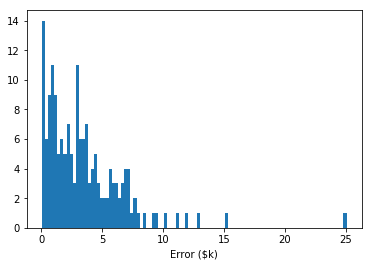

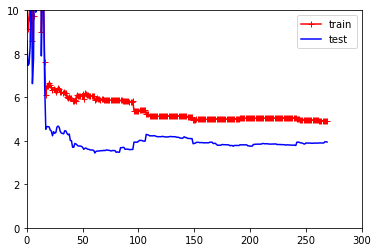

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X,train_y)
pred_y = lin_reg.predict(test_X)

# Outputs the intercept and coefficient of the model (theta_0 and theta_1 respectively)
print("Theta:")
print(lin_reg.intercept_, lin_reg.coef_)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(lin_reg, train_X, train_y)
plt.axis([0,300,0,10])

## Bagging Regressor using Linear Regression as Base

This example implements a bagging regressor with a linear regression model as the base classifier.  It shows the histogram of the price estimation error.  It also shows the learning curve for the model.

Theta:
37.971346224019584 [-3.11949527e-02  4.88083583e-02  8.33296341e-02  4.88762641e+00
 -2.23602370e+01  3.79242576e+00  5.51507569e-03 -1.28362515e+00
  3.03570389e-01 -9.71918315e-03 -1.05872173e+00  1.02544093e-02
 -5.42042249e-01]
MAE = 3.4966589498241043


[0, 300, 0, 10]

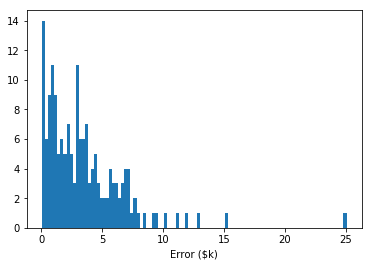

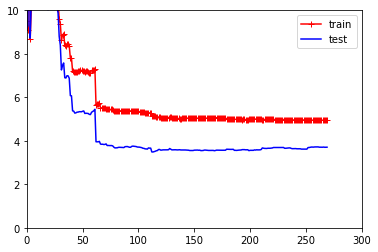

In [10]:
## Bagging with Linear Regression

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression

base_reg = LinearRegression()

bag_reg = BaggingRegressor(
    base_reg,
    n_estimators = 500,
    max_samples=1.0,
    n_jobs = -1,
    bootstrap=False) #Not replacement for this configuration

bag_reg.fit(train_X, train_y)

pred_y = bag_reg.predict(test_X)

# Outputs the intercept and coefficient of the model (theta_0 and theta_1 respectively)
print("Theta:")
print(lin_reg.intercept_, lin_reg.coef_)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(lin_reg, train_X, train_y)
plt.axis([0,300,0,10])

## Random Forest Regression Example

This example implements a random forest regressor using decision trees up to depth 10.  It shows the histogram of the price estimation error.  It also shows the learning curve for the model.

Theta:
39.0676034865034 [-5.41896135e-02  4.06444373e-02  2.65716919e-02  4.52127700e+00
 -2.19598064e+01  3.54591175e+00  7.70951655e-03 -1.22984540e+00
  3.01399219e-01 -9.48922928e-03 -1.02210279e+00  8.84100907e-03
 -5.23344551e-01]
MAE = 2.222767733456878


[0, 300, 0, 10]

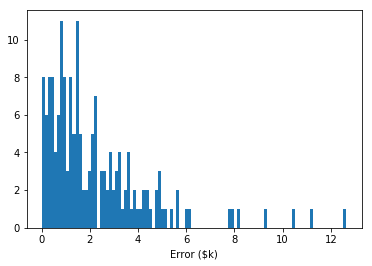

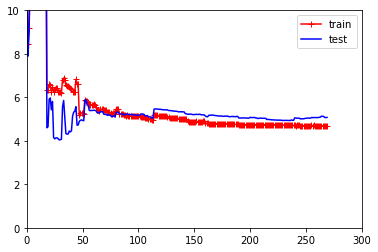

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=50, n_jobs=-1, max_depth=10)

rf_reg.fit(train_X, train_y)

pred_y = rf_reg.predict(test_X)

# Outputs the intercept and coefficient of the model (theta_0 and theta_1 respectively)
print("Theta:")
print(lin_reg.intercept_, lin_reg.coef_)

plt.figure("a")
plt.hist(abs(test_y - pred_y),bins=100)
plt.xlabel("Error ($k)")

print("MAE = " + str(mean_absolute_error(test_y, pred_y)))

plt.figure("b")
plot_learning_curves(lin_reg, train_X, train_y)
plt.axis([0,300,0,10])

## Random Forest Regressor: Feature Importance and Out of Bag Validation Score

This example shows a random forest regressor using decision trees constrained to a maximum depth of 10.  Out of bag score is enabled.  

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, n_jobs=-1, max_depth=10, oob_score=True)
rf_reg.fit(train_X, train_y)

for name, score in zip(boston_housing_data.feature_names, rf_reg.feature_importances_):
    print(name, score)
    
print("\n\nOut of Bag Validation:", rf_reg.oob_score_)

CRIM 0.03286861034296195
ZN 0.0011545057812899816
INDUS 0.005809413079362309
CHAS 0.0008244084843174658
NOX 0.02508285653390117
RM 0.28676435899913083
AGE 0.017221743338127815
DIS 0.052805164905148326
RAD 0.003757265170370122
TAX 0.012525620743861727
PTRATIO 0.0229284709713859
B 0.015341433178425175
LSTAT 0.5229161484717173


Out of Bag Validation: 0.8412992736573659
